**Dataset Loading**

In [1]:

!pip install gensim
!pip install openai


In [2]:
import time
import json
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import requests
from openai import OpenAI
from tenacity import retry, wait_random_exponential, stop_after_attempt
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.colab import userdata

In [3]:
import pandas as pd

# Загрузка данных из CSV файла
df = pd.read_csv('task-3-dataset.csv')
df_test = pd.read_csv('test50.csv')

In [4]:
df['label']= df['разметка'].replace({'+': 1, '-': 0})
df_test['label']= df_test['разметка'].replace({'+': 1, '-': 0})

<ipython-input-4-1cd0409078e0>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label']= df['разметка'].replace({'+': 1, '-': 0})
<ipython-input-4-1cd0409078e0>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['label']= df_test['разметка'].replace({'+': 1, '-': 0})


**BERT Embedings**

In [6]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_embedding(sentence):
    global counter

    # Tokenize and encode the sentence
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the mean of the last hidden state as the sentence embedding
    sentence_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    # Convert array to JSON string
    sentence_emb_json = json.dumps(sentence_emb.tolist())

    if counter < 3:
        print("Embedding: ", sentence_emb_json)
    elif counter == 3:
        print("Continuing to process, but not printing the rest...")

    counter += 1
    return sentence_emb_json

# Reset counter
counter = 0

# Generate embeddings
start_time = time.time()
df['embedding'] = df['отзывы'].apply(bert_embedding)
df_test['embedding'] = df_test['Отзывы'].apply(bert_embedding)
end_time = time.time()
df.to_csv('BERT.csv', index=False)
df_test.to_csv('BERT_test.csv', index=False)

Embedding:  [-0.26207399368286133, 0.04883361980319023, -0.048433419317007065, -0.34409186244010925, 0.9156331419944763, 0.4354860484600067, 0.144070103764534, 0.4357111155986786, -0.1939959079027176, -0.09515689313411713, 0.11884237080812454, -0.018402718007564545, -0.016932517290115356, 0.20056340098381042, -0.25894269347190857, 0.28102245926856995, 0.3567180931568146, -0.3831138014793396, -0.48636916279792786, 0.6948475241661072, -0.06246555969119072, 0.2301795333623886, -0.3936457335948944, 0.7862792015075684, -0.13045856356620789, -0.3303990960121155, -0.44806578755378723, 0.612186849117279, 0.08510251343250275, 0.6748281717300415, 0.21222509443759918, -0.2687261700630188, 0.1867929995059967, 0.3756869435310364, 0.012960073538124561, 0.12328293174505234, -0.31595948338508606, -0.3443858027458191, 0.08625801652669907, -0.501747190952301, -0.3191567659378052, 0.3827235996723175, -0.5123482942581177, -0.2537691295146942, -0.24838797748088837, -0.4270949959754944, -0.1325618475675583,

In [7]:
filenames = [
    'BERT.csv'
  ]

def prepare_data(filename):
    df = pd.read_csv(filename)
    X, y = [], []

    for idx, row in df.iterrows():
        try:
            # Convert string to list if necessary
            embedding = json.loads(row['embedding']) if isinstance(row['embedding'], str) else row['embedding']
            X.append(embedding)
            y.append(row['label'])
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in row {idx} of file {filename}: {e}")
            print(f"Faulty data: {row['embedding']}")
        except Exception as e:
            print(f"Unexpected error in row {idx} of file {filename}: {e}")

    return np.array(X), np.array(y)

# Dictionary to store the X and y for each embedding type
data_for_embeddings = {}

for filename in filenames:
    print(f"Processing file: {filename}")
    X, y = prepare_data(filename)
    data_for_embeddings[filename] = (X, y)
    print(f"Completed processing file: {filename}\n")

Processing file: BERT.csv
Completed processing file: BERT.csv



In [8]:
filenames = [
    'BERT_test.csv'
  ]

def prepare_data(filename):
    df = pd.read_csv(filename)
    X_test, Y_test = [], []

    for idx, row in df.iterrows():
        try:
            # Convert string to list if necessary
            embedding = json.loads(row['embedding']) if isinstance(row['embedding'], str) else row['embedding']
            X_test.append(embedding)
            Y_test.append(row['label'])
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in row {idx} of file {filename}: {e}")
            print(f"Faulty data: {row['embedding']}")
        except Exception as e:
            print(f"Unexpected error in row {idx} of file {filename}: {e}")

    return np.array(X_test), np.array(Y_test)

# Dictionary to store the X and y for each embedding type
data_for_embeddings = {}

for filename in filenames:
    print(f"Processing file: {filename}")
    X_test, Y_test = prepare_data(filename)
    data_for_embeddings[filename] = (X_test, Y_test)
    print(f"Completed processing file: {filename}\n")

Processing file: BERT_test.csv
Completed processing file: BERT_test.csv



In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
x_train, y_train = ros.fit_resample(x_train, y_train)

# show_class_balance(y_ros, classes)

In [ ]:
# pca = PCA(n_components=3)  # Уменьшаем до 50 компонент
# X_train_sc = pca.fit_transform(X_train)
# X_test_sc = pca.transform(X_test)
# print("Исходная размерность:", data.shape)
# print("Новая размерность после PCA:", data_pca.shape)

In [15]:
# model = SVC(C=5, gamma=0.01, kernel="rbf")
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [16]:
preds = model.predict(x_test)
accuracy = accuracy_score(y_test, preds)
accuracy

0.8333333333333334

In [17]:
preds = model.predict(X_test)
accuracy = accuracy_score(Y_test, preds)
accuracy

0.52

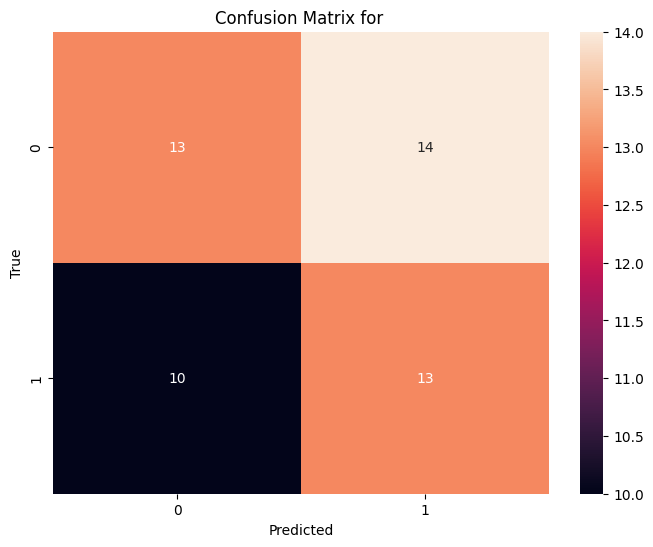

In [19]:
cm = confusion_matrix(Y_test, preds)

    # Visualization with custom gradient colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title(f"Confusion Matrix for ")
plt.xlabel('Predicted')

plt.ylabel('True')
plt.show()



**Обучение на qiskit**

In [22]:
pip install qiskit==1.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.6 MB/s eta 0:00:00
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.2.4
    Uninstalling qiskit-1.2.4:
      Successfully uninstalled qiskit-1.2.4


In [23]:
pip install qiskit-aer==0.13.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 45.5 MB/s eta 0:00:00


In [24]:
pip install qiskit-algorithms==0.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
pip install qiskit-optimization==0.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 11.2 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.28.240-py3-none-any.whl size=682834 sha256=61bb3aeb2ac1274206342c1bae85131e7d2c4d431a22958004ab8da17ad75294
  Stored in directory: /root/.cache/pip/wheels/1b/ec/59/cc07dedc67b032a492201f6f26c1f3c9e667ef208c9213ba6d
Successfully built docplex


In [20]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

# Получение вероятностей классов
probas_train = lr.predict_proba(x_train)
probas_test = lr.predict_proba(x_test)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from qiskit_aer import AerSimulator
# from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.connectors import TorchConnector

In [21]:
pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512552 sha256=a8804120d877acb02a7ce08df4b457ed80107b477b8c996253851e34d62274b5
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [25]:
from qiskit.circuit.library import ZZFeatureMap
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms import VQC
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
# from qiskit_machine_learning.datasets  import iric
from qiskit_machine_learning.algorithms import VQC
from qiskit.circuit.library import RealAmplitudes
from sklearn.datasets import load_wine
import time
# Параметры
feature_dim = 2

# Загрузка wine dataset
# data = load_wine()
# features = data.data[:, :feature_dim]  # Берём только первые 3 признака
# labels = data.target

# # Разделение данных на обучающую и тестовую выборки
# features_train, features_test, labels_train, labels_test = train_test_split(
#     features, labels, test_size=0.33, random_state=42
# )

# Определение квантового классификатора
start_time = time.time()
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=3)
vqc = VQC(feature_map=ZZFeatureMap(feature_dimension=feature_dim),
          ansatz=ansatz,
          optimizer=None)

# Обучение и оценка
vqc.fit(probas_train, y_train)

score = vqc.score(probas_test, y_test)
end_time = time.time()
print("Точность квантового классификатора:", score)
print('Time:', end_time-start_time)

Точность квантового классификатора: 0.8333333333333334
Time: 164.89803624153137


In [ ]:
score_test = vqc.score(probas_test, y_test)

In [ ]:
vqc.weights

array([ 0.39248135, -0.48051543,  1.14371136, -0.6895156 ,  0.8201862 ,
        0.24864091,  0.79524104,  0.22269079])

In [ ]:
vqc.predict(probas_test)

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
y_test

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

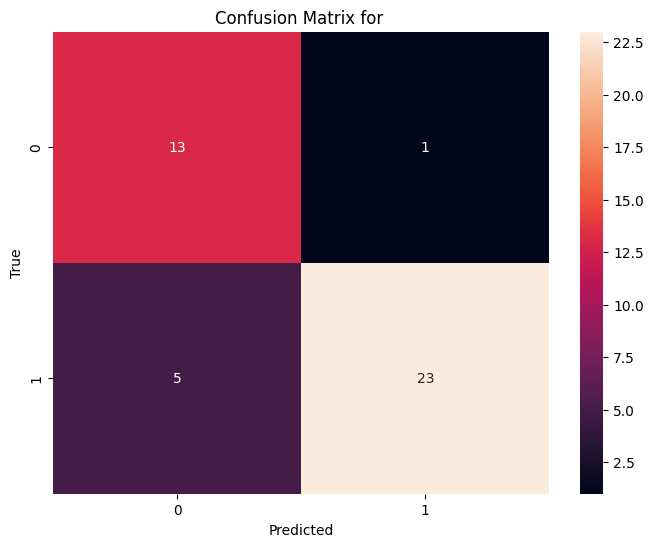

In [ ]:
cm = confusion_matrix(y_test, vqc.predict(probas_test))

    # Visualization with custom gradient colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title(f"Confusion Matrix for ")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()